In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2, l1_l2
import matplotlib.pyplot as plt

/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-27 22:47:27.927875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748396847.969404  769537 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748396847.987443  769537 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748396848.052783  769537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

# Carregando Modelos

In [4]:
model_f0 = tf.keras.models.load_model('models/tcc_auc_all_features_Fundamental_v5.keras')
model_h2 = tf.keras.models.load_model('models/tcc_auc_all_features_Fundamental_+_2º_Harmônico_v5.keras')
model = tf.keras.models.load_model('models/tcc_auc_all_features_Fundamental_+_2º_+_3º_Harmônicos_v5.keras')

# Carregando Dados

In [5]:
X_test_f0 = pd.read_parquet('f0/X_test_f0.parquet')
y_test_f0 = pd.read_parquet('f0/y_test_f0.parquet')

In [6]:
X_test_h2 = pd.read_parquet('f0_h2/X_test_h2.parquet')
y_test_h2 = pd.read_parquet('f0_h2/y_test_h2.parquet')

In [7]:
X_test = pd.read_parquet('f0_h2_h3/X_test.parquet')
y_test = pd.read_parquet('f0_h2_h3/y_test.parquet')

In [8]:
datasets = {
    'Fundamental': {
        'X_test': X_test_f0,
        'y_test': y_test_f0,
        'model': model_f0
    },
    'Fundamental + 2º Harmônico': {
        'X_test': X_test_h2,
        'y_test': y_test_h2,
        'model': model_h2
    },
    'Fundamental + 2º + 3º Harmônicos': {
        'X_test': X_test,
        'y_test': y_test,
        'model': model
    }
}

## LSTM

In [ ]:
def create_sequence(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length - 1])
    return np.array(X), np.array(y)

X_test_f0_seq, y_test_f0_seq = create_sequence(X_test_f0.values, y_test_f0.values, 20)
X_test_h2_seq, y_test_h2_seq = create_sequence(X_test_h2.values, y_test_h2.values, 20)
X_test_seq, y_test_seq = create_sequence(X_test.values, y_test.values, 20)
        

In [ ]:
datasets_seq = {
    'Fundamental': {
        'X_test': X_test_f0_seq,
        'y_test': y_test_f0_seq
    },
    'Fundamental + 2º Harmônico': {
        'X_test': X_test_h2_seq,
        'y_test': y_test_h2_seq
    },
    'Fundamental + 2º + 3º Harmônicos': {
        'X_test': X_test_seq,
        'y_test': y_test_seq
    }
}

# Inferência

In [32]:
def evaluate_model(model, X_test, y_test, threshold):
    y_prob = model.predict(X_test).ravel()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_test_1d = y_test.squeeze()
    y_pred = (y_prob > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test_1d, y_pred).ravel()
    taxa_fp = fp/(tn + fp)
    taxa_detec = tp/(tp + fp)

    print(classification_report(y_test_1d, y_pred))
    print(pd.crosstab(y_test_1d, y_pred, rownames=['Real'], colnames=['Previsão'], margins=True))
    print('Taxa de Falsos Positivos:', taxa_fp)
    print('Taxa de Detecção:', taxa_detec)
    print(f'AUC: {roc_auc:.4f}')
    print(f'Threshold ótimo (tpr - fpr): {optimal_threshold:.4f}')

    return roc_auc, optimal_threshold, fpr, tpr

In [33]:
results = {}

threshold_desejado = 0.9897 

for dataset_name, data in datasets.items():
    print(f"Evaluating {dataset_name} dataset...")
    roc_auc, optimal_threshold, fpr, tpr = evaluate_model(data['model'], data['X_test'], data['y_test'], threshold=threshold_desejado)
    results[dataset_name] = {
        'model': model,
        'auc': roc_auc,
        'threshold': optimal_threshold,
        'fpr': fpr,
        'tpr': tpr
    }

Evaluating Fundamental dataset...
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1126
           1       0.98      0.15      0.25       282

    accuracy                           0.83      1408
   macro avg       0.90      0.57      0.58      1408
weighted avg       0.85      0.83      0.77      1408

Previsão     0   1   All
Real                    
0         1125   1  1126
1          241  41   282
All       1366  42  1408
Taxa de Falsos Positivos: 0.0008880994671403197
Taxa de Detecção: 0.9761904761904762
AUC: 0.8030
Threshold ótimo (tpr - fpr): 0.0966
Evaluating Fundamental + 2º Harmônico dataset...
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1126
           1       1.00      0.05      0.09       282

    accuracy                           0.81      1408
   macro avg       0.90      0.52   

# CSM e MSC

In [36]:
X_test_rec = pd.read_csv('f0/X_test_rec_f0.csv')
y_test_f0 = pd.read_parquet('f0/y_test_f0.parquet')

X_test_rec_nh = X_test_rec.iloc[:, :500].values.astype(np.complex128)

In [37]:
from sklearn.metrics import roc_curve

M = 500
alfa=0.05

teta = np.angle(X_test_rec_nh)
y_test_only_1=np.flatnonzero(y_test)
y_test_only_0=np.flatnonzero(y_test==0)
## CSM
CSM=(np.power((1/M)*np.sum(np.cos(teta),axis=1),2))+(np.power((1/M)*np.sum(np.sin(teta),axis=1),2))

from scipy.stats.distributions import chi2

VC_CSM=chi2.ppf(1-alfa, df=2)/(2*M)
VC_CSM
y_CSM_txd=(CSM[y_test_only_1] > VC_CSM)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_CSM_txd = np.multiply(y_CSM_txd, 1)

y_CSM_txd=np.mean(y_CSM_txd)


y_CSM_fp=(CSM[y_test_only_0] > VC_CSM)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_CSM_fp = np.multiply(y_CSM_fp, 1)

y_CSM_fp=np.mean(y_CSM_fp)

y_CSM=(CSM > VC_CSM)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_CSM = np.multiply(y_CSM, 1)

fpr_CSM, tpr_CSM, thresholds_CSM = roc_curve(y_test,CSM.transpose())
print(y_CSM_txd)
print(y_CSM_fp)
## MSC
MSC=(np.abs(np.sum(X_test_rec_nh,axis=1))**2)/(M*np.sum((np.abs(X_test_rec_nh)**2),axis=1))
MSC = np.reshape(MSC,(1,len(MSC)))

VC_MSC=1-(alfa**(1/(M-1)))
VC_MSC
y_MSC_txd=(MSC[0,y_test_only_1] > VC_MSC)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_MSC_txd = np.multiply(y_MSC_txd, 1)

y_MSC_txd=np.mean(y_MSC_txd)

from numpy import matlib

y_MSC_fp=(MSC[0, y_test_only_0] > np.matlib.repmat(VC_MSC,1096,1))
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_MSC_fp = np.multiply(y_MSC_fp, 1)

y_MSC_fp=np.mean(y_MSC_fp)

fpr_MSC, tpr_MSC, thresholds_MSC = roc_curve(y_test,MSC.transpose())


0.851063829787234
0.11811722912966252


In [38]:
# Supondo que você já tenha as curvas externas:
results['CSM'] = {
    'fpr': fpr_CSM, 
    'tpr': tpr_CSM, 
    'auc': auc(fpr_CSM, tpr_CSM),
    'label': 'CSM'
}

results['MSC'] = {
    'fpr': fpr_MSC, 
    'tpr': tpr_MSC, 
    'auc': auc(fpr_MSC, tpr_MSC),
    'label': 'MSC'
}

# Curva ROC

In [34]:
def plot_all_roc_curves(results):
    plt.figure(figsize=(10, 8))
    
    # Plotar cada curva do dicionário
    for key in results:
        data = results[key]
        plt.plot(
            data['fpr'], 
            data['tpr'], 
            linewidth=2,
            label=f"{data.get('label', key)} (AUC = {data['auc']:.2f})"
        )
    
    # Linha de referência
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Comparação de Curvas ROC - RNA', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.show()

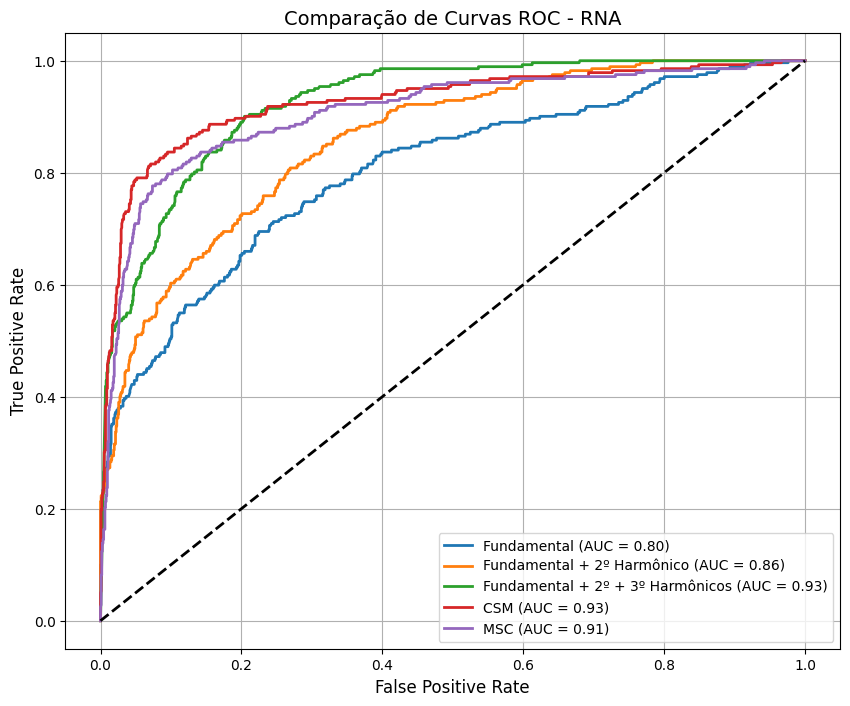

In [39]:
# Após o loop de avaliação dos datasets, adicione:
plot_all_roc_curves(results)